<a href="https://colab.research.google.com/github/louis75020/ML-for-business/blob/Regression-model/ML_for_business_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression models

# TODO

- Univariate analysis : geographical data + categorical adequacy tests

- Multivariate analysis : correlation Features/Response

- Feature selection : BIC backward ?? Wo uncorellated variables?

## Imports

In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import scipy.stats
import seaborn as sns

In [4]:
pip install tpot

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 157.5MB 74kB/s 
     |████████████████████████████████| 163kB 56.1MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11957 sha256=be9b33e9db9ec3d90a53c20fd97ff07c5f7b9b94ab3354d523079c9689c4bc88
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [5]:
import tpot
from tpot.builtins import StackingEstimator

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
!pip install missingno

In [7]:
import missingno

## Notes

*STEPS*

- Loading dataset
- Univariate analysis
- Multivariate analysis
- Missing values
- Preprocessing
- Modeling, evaluation
- Overfitting

NOTES

package missingno for missing value

histogramme : sn.displot()

pd.loc / pd.iloc

sklearn.input.Iterative

## 0. Data importation



The data will be downloaded via github. We need 2 files :

- data_train_insurance.csv

- data_type.csv

In [8]:
url_datatypes = "https://raw.githubusercontent.com/louis75020/ML-for-business/Regression-model/data_type.csv"
df_datatypes = pd.read_csv( url_datatypes,
                            sep = ';',
                            header = 0,
                           #encoding = "iso-8859-1" 
                           )
# check
df_datatypes.head()

,VarName,Type
0,Id,object
1,Response_Market_Index,float64
2,PROD_Formula,object
3,PER_sex,object
4,PER_Sex_Second_Driver,object


In [9]:
def get_types_dictionnary (dataframe = df_datatypes) :

  keys = dataframe['VarName']
  values = dataframe['Type']

  return dict( zip(keys, values) )

In [10]:
datatypes = get_types_dictionnary()
#datatypes

In [11]:
url_insurance_data = "https://raw.githubusercontent.com/louis75020/ML-for-business/Regression-model/data_train_insurance.csv"
df_insurance = pd.read_csv( url_insurance_data, 
                            sep = ";",
                            header = 0,
                            dtype = datatypes,
                            na_values = ['?'],
                            keep_default_na = True,
                            #encoding = "iso-8859-1" 
                           )

#check
df_insurance.head()

,Id,Response_Market_Index,PROD_Formula,PER_sex,PER_Sex_Second_Driver,VEH_Actual_Value,CLA_HISTORY,CLA_HISTORY_1Y,CLA_HISTORY_3Y,CLA_BM_TPL_DECLARED,BEH_Mileage,PER_KIDS_ON_BOARD_ID,VEH_Number_of_doors,VEH_Top_Speed,BEH_Number_Year_Insured,VEH_TransmissionId,PER_Age_Main_Driver,PER_License_Age_Main_Driver,PER_License_Age_Second_Driver,PER_Matrimonial_Status,VEH_Age,VEH_Injection_Mode,VEH_fuel_type,BEH_vehicule_usage,VEH_Drive_type,VEH_Body,VEH_Segment,PER_Parking_Type,CLA_BM,VEH_engine_HP,VEH_pw_proportion,VEH_High_Risk_Vehicle,PER_previous_insurer,PER_Is_second_driver,PER_Age_oldest_child,PER_Second_Driver_Age,PER_Insured_Before,VEH_Weight,GEO_Lat,GEO_Long
0,1638099,435.0,BASIC,2,0,4600.0,1.0,1.0,1.0,1.0,13.0,3,4.0,160.0,10.0,7,59.0,31.0,-1.0,2,15.0,389999,1,1,50001,9,30003,3,10.0,90.0,59.0,2,5,1,-99.0,-1.0,2,1125.0,-1.790876,-0.431147
1,1657342,609.0,FULL,1,0,68315.0,1.0,1.0,1.0,2.0,15.0,1,5.0,248.0,6.0,7,32.0,15.0,-1.0,2,3.0,380002,1,1,50002,9,30005,1,6.0,218.0,106.0,2,17,1,2.0,-1.0,2,1510.0,1.675824,-4.431147
2,1657529,609.0,FULL,1,0,68315.0,1.0,1.0,1.0,2.0,15.0,1,5.0,248.0,6.0,7,32.0,15.0,-1.0,2,3.0,380002,1,1,50002,9,30005,1,6.0,218.0,106.0,2,17,1,2.0,-1.0,2,1510.0,1.675824,-4.431147
3,1662071,404.0,FULL,1,2,11005.0,1.0,1.0,1.0,2.0,14.0,1,5.0,173.0,7.0,7,31.0,7.0,12.0,2,8.0,380002,1,1,50001,9,30002,3,7.0,80.0,51.0,2,6,2,1.0,31.0,2,1170.0,-0.440876,1.285553
4,1662074,404.0,FULL,1,2,11005.0,1.0,1.0,1.0,2.0,14.0,1,5.0,173.0,7.0,7,31.0,7.0,12.0,2,8.0,380002,1,1,50001,9,30002,3,7.0,80.0,51.0,2,6,2,1.0,31.0,2,1170.0,-0.440876,1.285553


In [12]:
df_insurance.dtypes

Id                                object
Response_Market_Index            float64
PROD_Formula                      object
PER_sex                           object
PER_Sex_Second_Driver             object
VEH_Actual_Value                 float64
CLA_HISTORY                      float64
CLA_HISTORY_1Y                   float64
CLA_HISTORY_3Y                   float64
CLA_BM_TPL_DECLARED              float64
BEH_Mileage                      float64
PER_KIDS_ON_BOARD_ID              object
VEH_Number_of_doors              float64
VEH_Top_Speed                    float64
BEH_Number_Year_Insured          float64
VEH_TransmissionId                object
PER_Age_Main_Driver              float64
PER_License_Age_Main_Driver      float64
PER_License_Age_Second_Driver    float64
PER_Matrimonial_Status            object
VEH_Age                          float64
VEH_Injection_Mode                object
VEH_fuel_type                     object
BEH_vehicule_usage                object
VEH_Drive_type  

We will deal with the geographical data later

## Preparation : Split qualtitative/quantitative + train/test

In [13]:
df_insurance.describe()

,Response_Market_Index,VEH_Actual_Value,CLA_HISTORY,CLA_HISTORY_1Y,CLA_HISTORY_3Y,CLA_BM_TPL_DECLARED,BEH_Mileage,VEH_Number_of_doors,VEH_Top_Speed,BEH_Number_Year_Insured,PER_Age_Main_Driver,PER_License_Age_Main_Driver,PER_License_Age_Second_Driver,VEH_Age,CLA_BM,VEH_engine_HP,VEH_pw_proportion,PER_Age_oldest_child,PER_Second_Driver_Age,VEH_Weight,GEO_Lat,GEO_Long
count,9983.000000,9.983000e+03,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9217.000000,9933.000000,9933.000000,9933.000000,9933.000000,8931.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9983.000000,9983.000000
mean,493.635824,2.076923e+04,1.508205,1.124836,1.312393,1.646431,13.309977,4.612455,187.541830,6.478808,38.314809,16.939495,0.845482,8.788281,6.434109,116.328300,64.510823,-44.718011,4.390516,1314.165408,-0.002146,-0.007880
std,268.707675,2.473360e+04,1.949901,0.952200,1.510256,2.180726,1.016209,0.726908,24.391045,3.959938,12.224230,11.614645,5.505131,4.984428,3.768526,42.120307,14.925362,55.379085,13.076905,249.981410,1.344643,2.032372
min,162.000000,-1.765000e+03,1.000000,1.000000,1.000000,-1.000000,12.000000,2.000000,0.000000,-1.000000,18.000000,0.000000,-1.000000,0.000000,0.000000,24.000000,30.000000,-99.000000,-1.000000,600.000000,-2.440876,-4.764447
25%,341.580000,7.803000e+03,1.000000,1.000000,1.000000,1.000000,13.000000,4.000000,175.000000,3.000000,29.000000,8.000000,-1.000000,5.000000,3.000000,90.000000,55.000000,-99.000000,-1.000000,1155.000000,-1.274176,-1.547747
50%,407.070000,1.499800e+04,1.000000,1.000000,1.000000,1.000000,13.000000,5.000000,187.000000,8.000000,35.000000,15.000000,-1.000000,8.000000,7.000000,110.000000,63.000000,-99.000000,-1.000000,1318.000000,0.009124,0.002253
75%,530.000000,2.688250e+04,1.000000,1.000000,1.000000,1.000000,14.000000,5.000000,201.000000,10.000000,45.000000,24.000000,-1.000000,12.000000,10.000000,140.000000,71.000000,10.000000,-1.000000,1470.000000,0.809124,1.702253
max,2604.930000,1.132190e+06,11.000000,11.000000,11.000000,12.000000,18.000000,5.000000,325.000000,10.000000,85.000000,59.000000,47.000000,29.000000,10.000000,625.000000,304.000000,27.000000,69.000000,2475.000000,3.055324,4.902253


We will first split data according to their types (quantitative/ qualitative/   geographical ... ).

We will also review the data types (categorical as integers ...)

**ID** : to delete (no information to get from the id, if we need to access lines we will use the pandas auto-generated iterator).

**Response_market_index**

Quantitative variable, the one we want to explain. We will check for missing values (in order to use these ones for the test dataset).

**Product Information**

Qualitative variable. See number of modalities. To cast to integer. Eventually we'll have ton get the associated dummies.

**PER: Personnal information**

- PER_SEX, PER_SEX_SECOND_DRIVER : sexe 1/2, qualitative variable we'll need to get dummies. 
- PER_KIDS_ON_BOARD_ID : ??? maybe the number of kids of the car's owner. It maybe requires to be cast to integer, and to get dummies
- PER_AGE_MAIN_DRIVER : quantitative.
- PER_LICENCE_MAIN_DRIVER, PER_LICENCE_SECOND_DRIVER : quantitative
- PER_MATRINOMIAL_STATUS : qualitative, get_dummies, to integer
- PER_PARKING_TYPE : qualitative, get_dummies, to integer
- PER_previous_insurer 	: qualitative, get dummies
- PER_Is_second_driver 	: ??? flag 0/1
- PER_Age_oldest_child 	: quantitative
- PER_Second_Driver_Age 	: quantitative
- PER_Insured_Before : qualitative (flag)

We will have to take into account :

- CASE wo 2nd driver
- ASE wo children

**VEH : Vehicle information**

- VEH_Actual_Value : quantitative
- VEH_Number_of_doors : quantitative
- VEH_Top_Speed : quantitative
- VEH_TransmissionId : ?? qualitative, seems to be a flag
- VEH_Age : quantitative                
- VEH_Injection_Mode : ?? qualitative               
- VEH_fuel_type : qualitative             
- VEH_Drive_type : qualitative
- VEH_Body : ?? qualitative
- VEH_Segment : qualitative
- VEH_engine_HP : quantitative
- VEH_pw_proportion : quantitative
- VEH_High_Risk_Vehicle : qualitative
- VEH_Weight : quantitative

**CLA : Claims information**

Not so sure what it means. It seems to take integer values from 1 to 10. It could be treated as a qualitative or quantitative variable if we could be sure that there is some kind of distance between 11 and 1. We'll suppose it quantitative (to simplify analysis) but it's maybe a mistake.

- CLA_HISTORY : qualitative                   
- CLA_HISTORY_1Y : qualitative                     
- CLA_HISTORY_3Y : qualitative                    
- CLA_BM_TPL_DECLARED : qualitative       
- CLA_BM : quantitative  

**BEH : Behavioral information**

- BEH_Mileage : quantitative
- BEH_Number_Year_Insured : quantitative
- BEH_vehicule_usage : qualitative

**GEO : geographical data**
(GEO_LAT, GEO_LONG) : check for norm of representation

It seems that there is more qualitative variables as expected by given types. Encoding of these are bad (1/2 instead of 0/1).

In [14]:
qualitative = ["PROD_Formula",
               "PER_sex",
               "PER_Sex_Second_Driver",
               "PER_KIDS_ON_BOARD_ID",
               "VEH_TransmissionId",
               "PER_Matrimonial_Status",
               "VEH_Injection_Mode",
               "VEH_fuel_type",
               "BEH_vehicule_usage",
               "VEH_Drive_type",
               "VEH_Body",
               "VEH_Segment",
               "PER_Parking_Type",
               "VEH_High_Risk_Vehicle",
               "PER_previous_insurer",
               "PER_Is_second_driver",
               "PER_Insured_Before"]

quantitative = ["VEH_Actual_Value",
                "VEH_Top_Speed",
                "PER_Age_Main_Driver",
                "PER_License_Age_Main_Driver",
                "PER_License_Age_Second_Driver",
                "VEH_Age",
                "VEH_engine_HP",
                "VEH_pw_proportion",
                "PER_Age_oldest_child",
                "PER_Second_Driver_Age",
                "VEH_Weight"] 

as_quantitative = ["BEH_Mileage",
                   "BEH_Number_Year_Insured", 
                   "VEH_Number_of_doors", 
                   "CLA_HISTORY",
                   "CLA_HISTORY_1Y",
                   "CLA_HISTORY_3Y",
                   "CLA_BM_TPL_DECLARED", 
                   "CLA_BM"]

geographical = ["GEO_Lat", "GEO_Long"] 	 	 	 	 	 	

In [15]:
del df_insurance["Id"]

We will split now the database into train/test to avoid any bias while analyzing the data (even if it is not as conveniant...)

The final split will be about 60/ 20/ 20.

In [16]:
df_insurance['Response_Market_Index'].isnull().sum()

0

In [17]:
y = df_insurance['Response_Market_Index']
del df_insurance['Response_Market_Index'] 
#seed(2021)
X_train, X_test, y_train, y_test = train_test_split(df_insurance, y, test_size=0.20)

print ('shape X: ', X_train.shape, 'shape y: ', y_train.shape)

shape X:  (7986, 38) shape y:  (7986,)


In [18]:
del url_datatypes, url_insurance_data, df_datatypes, datatypes

## 1. Univariate analysis

We will perform the engineering for missing values later.

### Response variable

In [ ]:
class Custom_univariate_statistics():

  is_categorical = False

  def quantitative_adequacy_tests(self, x):

    # initialisation
    output = dict()
    best_pvalue = 0
    best_params = {}
    best_law = 'uniform'

    to_test = ['gamma',
               'alpha',
               'beta',
               'skewnorm',
               'expon',
               'cauchy',
               'norm',
               'weibull_min',
               'uniform',
               'gumbel_r']

    for k in to_test :

      params = getattr(scipy.stats, k).fit(x)
      test = scipy.stats.kstest(x, k, args = params)
      name = k + ' ks test'
      output[ name ] = test
      if test[1] > best_pvalue :
        best_pvalue = test[1]
        if k in ['alpha',
                 'gamma',
                 'skewnorm'] : best_params = {'a': params[0],
                                              'loc': params[1],
                                              'scale':params[2]}

        elif k in ['beta'] : best_params = {'a': params[0],
                                          'b': params[1],
                                          'loc': params[2],
                                          'scale':params[3]}
        elif k in ['cauchy',
                 'expon',
                 'gumbel_r',
                 'norm',
                 'uniform'] : best_params = {'loc': params[0],
                                            'scale':params[1]}

        elif k in ['weibull_min'] : best_params = {'c':params[0],
                                                 'loc': params[1],
                                                 'scale':params[2]}
        else : print('problem')

        best_law = k

    output = pd.DataFrame(output)
    output = output.transpose()
    output.columns = ['stat value', 'p-value']

    return output, best_law, best_params


  # def qualitative_adequacy_tests(self, xx):
  #
  #   x = xx.dropna()
  #   output = dict()
  #   best_pvalue = 0
  #   best_params = {}
  #   best_law = 'randint'
  #
  #   to_test = ['binom', 'geom', 'hypergeom', 'poisson', 'randint', 'nbinom', 'nhypergeom']
  #
  #   for k in to_test :
  #
  #     params = getattr(scipy.stats, k).fit(x)
  #     test = scipy.stats.kstest(x, k, args = params)
  #     name = k + ' ks test'
  #     output[ name ] = test
  #     if test[1] > best_pvalue :
  #       best_pvalue = test[1]
  #       if k in ['binom', 'nbinom'] : best_params = {'n': params[0], 'p': params[1], 'loc': params[2]}
  #       elif k in ['geom', 'nhypergeom'] : best_params = {'p':params[0], 'loc': params[1]}
  #       elif k in ['hypergeom'] : best_params = {"M":params[0], "n":params[1], "N":params[2], "loc":params[3]}
  #       elif k in ['poisson'] : best_params = {'mu':params[0], 'loc':params[1]}
  #       elif k in ['runif'] : best_params = { "low":params[0], "high":params[1], "loc":params[2]}
  #       else : print('problem')
  #       best_law = k
  #
  #   output = pd.DataFrame(output)
  #   output = output.transpose()
  #   output.columns = ['stat value', 'p-value']
  #
  #   return output, best_law, best_params




  def get_univariate_statistics(self, x) :

    if self.is_categorical :
      self.get_qualitative_univariate_statistics(x)
    else :
      self.get_quantitative_univariate_statistics(x)


  def get_quantitative_univariate_statistics(self, xx, as_na = [-1., -1, -99., -99, 0, 0.]):

    # summary
    print('__________________Summary statistics of the response variable__________________')
    print(xx.describe())

    # preprocessing
    x = xx.dropna().values
    for na_value in as_na :
      x = x[ x != na_value ]

    # adequacy test
    print('_______________________Adequacy tests_____________________________')

    tests, best_law, best_params = self.quantitative_adequacy_tests(x)
    best_params_dict = tuple(best_params.values())
    #print(best_params_dict)
    print(tests)


    #plots
    print('_______________________Plots cdf/df_______________________')

    fig = figure()
    figsize(10,10)

    #df
    subplot(2,2,1)
    ax = sns.kdeplot(x, fill = True)
    ax.patch.set_facecolor('white')
    ax.set_xlabel('values', fontsize = 15)
    ax.set_ylabel('frequency', fontsize = 15)
    title('Kernel estimator density')
    grid(True)

    # best df
    subplot(2,2,2)
    x_vals = linspace(min(x), max(x), len(x))
    best_law_module = getattr(scipy.stats, best_law)
    y_vals = best_law_module.pdf(x_vals, **best_params)
    plot(x_vals, y_vals)
    xlabel('values')
    ylabel('frequency')
    title('Best found density :'+ best_law)
    grid(True)

    #qqplot
    ax2 = subplot(2,2,3)
    res = scipy.stats.probplot(x,
                               dist = getattr(scipy.stats, best_law),
                               sparams = best_params_dict,
                               plot = ax2)
    ax.set_title("qq_plot for best law and best params")

    #cdf
    ax3 = fig.add_subplot(2,2,4)
    ordered_x = sort(x)
    cdf_x = cumsum( 1/len(x) * ones((len(x),)) )
    ax3 = plot(ordered_x, cdf_x)
    title('CDF')
    grid(True)
    xlabel('x values')
    ylabel('P(x<=t)')

    show(fig)

  def get_qualitative_univariate_statistics(self, xx, as_na = []):


    # summary
    print('__________________Summary statistics of the response variable__________________')
    print(xx.describe())

    # adequacy test
    # print('_______________________Adequacy tests_____________________________')
    #
    # tests, best_law, best_params = self.qualitative_adequacy_tests(x)
    # best_params_dict = tuple(best_params.values())
    # #print(best_params_dict)
    # print(tests)

    # preprocessing
    x = xx.dropna().values
    for na_value in as_na :
      x = x[ x!= na_value]

    print('_________________plots________________')
    figsize(10,10)
    sns.displot(x)
    grid(True)
    title('Histogram for '+element)
    show()

    #cdf
    ordered_x = sort(x)
    cdf_x = cumsum( 1/len(ordered_x) * ones(ordered_x.shape) )
    subplot(2, 2 ,2)
    plot(ordered_x, cdf_x)
    xlabel('x values')
    ylabel('P(x<=t)')
    grid(True)
    title('CDF of the vraiable ' + element)
    show()

__________________Summary statistics of the response variable__________________
count    7986.000000
mean      495.454438
std       271.740380
min       162.000000
25%       342.000000
50%       407.000000
75%       532.750000
max      2604.930000
Name: Response_Market_Index, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value        p-value
gamma ks test          0.199838  1.942816e-277
alpha ks test          0.029666   1.572170e-06
beta ks test           0.134029  4.948700e-125
skewnorm ks test       0.214865  1.149197e-320
expon ks test          0.250597   0.000000e+00
cauchy ks test         0.142011  2.579936e-140
norm ks test           0.205320  7.595500e-293
weibull_min ks test    0.815123   0.000000e+00
uniform ks test        0.644633   0.000000e+00
gumbel_r ks test       0.124434  7.895712e-108
_______________________Plots cdf/df_______________________


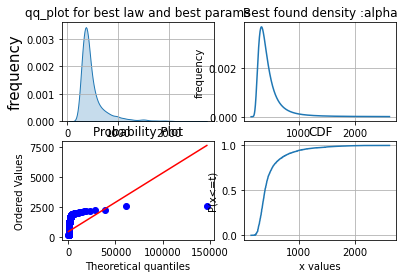

In [ ]:


analyzer = Custom_univariate_statistics()

analyzer.is_categorical = False

analyzer.get_univariate_statistics(y_train)


**About the law** alpha, even if the kolmogorov-smirnov test and the qq-plot are bad. Let's note that the KS test behaves badly with large data (size > 100). To find the most likely density function, we performed ks-tests on data against laws from a defined family and with the MLE parameters. 

**About descriptive statistics** The max seems out of the natural confidence interval of the gaussian law. We won't perform any feature engineering at this point (because we are not studying Y but $E[Y|X]$...

### Quantitative variables

In [ ]:
X_train[quantitative].describe()

,VEH_Actual_Value,VEH_Top_Speed,PER_Age_Main_Driver,PER_License_Age_Main_Driver,PER_License_Age_Second_Driver,VEH_Age,VEH_engine_HP,VEH_pw_proportion,PER_Age_oldest_child,PER_Second_Driver_Age,VEH_Weight
count,7.986000e+03,7946.000000,7946.000000,7946.000000,7141.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000
mean,2.077883e+04,187.766927,38.194941,16.845709,0.810811,8.798389,116.572993,64.605714,-44.825069,4.309464,1315.393783
std,2.543393e+04,24.035736,12.202709,11.595733,5.460803,5.000353,41.927616,14.886200,55.364199,13.034649,248.375705
min,-1.765000e+03,0.000000,18.000000,0.000000,-1.000000,0.000000,24.000000,30.000000,-99.000000,-1.000000,600.000000
25%,7.800000e+03,175.000000,29.000000,8.000000,-1.000000,5.000000,90.000000,55.000000,-99.000000,-1.000000,1160.000000
50%,1.497650e+04,187.000000,35.000000,15.000000,-1.000000,8.000000,110.000000,63.000000,-99.000000,-1.000000,1320.000000
75%,2.706800e+04,201.000000,45.000000,24.000000,-1.000000,12.000000,140.000000,72.000000,10.000000,-1.000000,1470.000000
max,1.132190e+06,325.000000,85.000000,59.000000,43.000000,29.000000,625.000000,304.000000,27.000000,69.000000,2475.000000


**VEH_Actual_Value** min value is negative?? Does it have a sense?? Maybe we shoul apply there the positive part function.

**7945/7986** Once again BEH_Mileage, VEH_Top_Speed, CLA_History_1Y, CLA_History_3Y, CLA_BM_TPL_DECLARED 	BEH_Number_Year_Insured 	PER_Age_Main_Driver 	PER_License_Age_Main_Driver, VEH_Age 	CLA_BM 	VEH_engine_HP 	VEH_pw_proportion 	PER_Age_oldest_child 	PER_Second_Driver_Age 	VEH_Weight have 7945/7986. We will check later if these missing values are really the same. If this is the case; we'll have to find a solution (which is not inputation) to deal with.

**VEH_TOP_SPEED** min at 0?? Broken vehicle?

**CLA** The means are not the same, but we will check for linear independance anyway.

**CLA_BM_TPL_DECLARED, 	BEH_Number_Year_Insured** min at -1 : additionnal missing values ?

**PER_License_Age_Main_Driver** min at 0 : licence-free driver?

**PER_License_Age_Second_Driver, PER_Second_Driver_Age** min at -1 : it is maybe the vehicle with only 1 driver. We should cast to 0/1 flag and second_driver (if not 0-value).

**PER_Age_oldest_child** min at -99 -> should be casted to 0.



################################################
________________VEH_Actual_Value__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7.986000e+03
mean     2.077883e+04
std      2.543393e+04
min     -1.765000e+03
25%      7.800000e+03
50%      1.497650e+04
75%      2.706800e+04
max      1.132190e+06
Name: VEH_Actual_Value, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


                     stat value        p-value
gamma ks test          0.206682  1.274704e-293
alpha ks test          0.998585   0.000000e+00
beta ks test           0.047798   4.171268e-16
skewnorm ks test       0.177250  4.615109e-216
expon ks test          0.136733  9.534321e-129
cauchy ks test         0.169914  1.391260e-198
norm ks test           0.212472  2.814201e-310
weibull_min ks test    0.067942   4.151226e-32
uniform ks test        0.912047   0.000000e+00
gumbel_r ks test       0.076377   1.832265e-40
_______________________Plots cdf/df_______________________


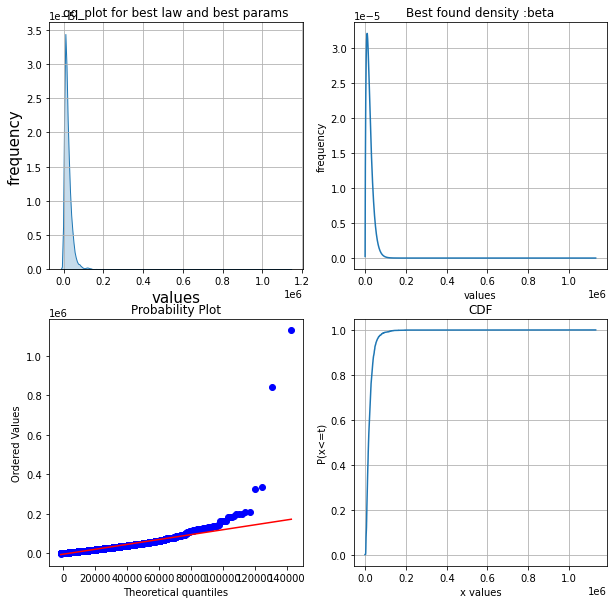

################################################
________________VEH_Top_Speed__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean      187.766927
std        24.035736
min         0.000000
25%       175.000000
50%       187.000000
75%       201.000000
max       325.000000
Name: VEH_Top_Speed, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.035707  3.404862e-09
alpha ks test          0.040189  1.559272e-11
beta ks test           0.036794  9.774530e-10
skewnorm ks test       0.035523  4.190713e-09
expon ks test          0.407737  0.000000e+00
cauchy ks test         0.083770  1.093476e-48
norm ks test           0.045433  1.273183e-14
weibull_min ks test    0.845066  0.000000e+00
uniform ks test        0.410968  0.000000e+00
gumbel_r ks test       0.077599  7.722283e-42
_______________________Plots cdf/df_______________________


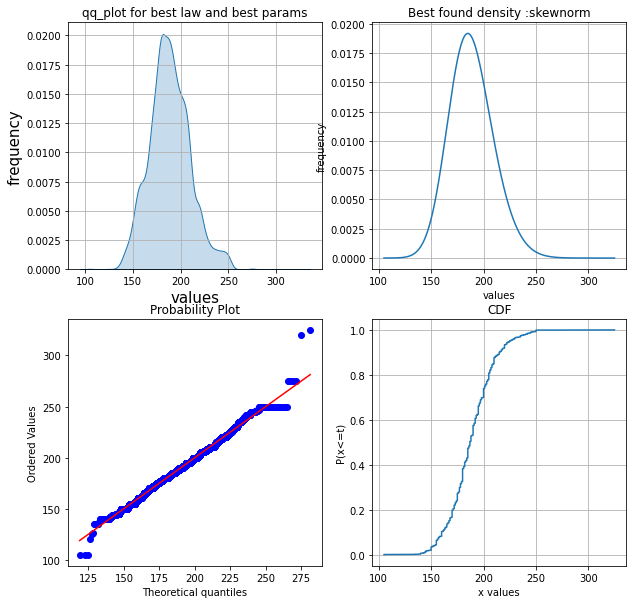

################################################
________________PER_Age_Main_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean       38.194941
std        12.202709
min        18.000000
25%        29.000000
50%        35.000000
75%        45.000000
max        85.000000
Name: PER_Age_Main_Driver, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


                     stat value        p-value
gamma ks test          0.045866   6.049405e-15
alpha ks test          0.054289   9.102521e-21
beta ks test           0.052970   8.630106e-20
skewnorm ks test       0.047942   2.739917e-16
expon ks test          0.214200  4.320610e-317
cauchy ks test         0.126835  1.864257e-111
norm ks test           0.113219   6.754119e-89
weibull_min ks test    0.737364   0.000000e+00
uniform ks test        0.352489   0.000000e+00
gumbel_r ks test       0.058836   2.564573e-24
_______________________Plots cdf/df_______________________


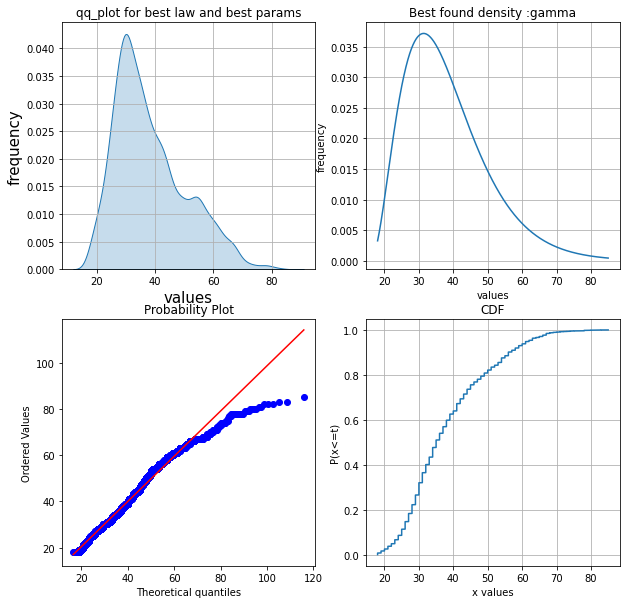

################################################
________________PER_License_Age_Main_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean       16.845709
std        11.595733
min         0.000000
25%         8.000000
50%        15.000000
75%        24.000000
max        59.000000
Name: PER_License_Age_Main_Driver, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


                     stat value        p-value
gamma ks test          0.050449   2.074417e-17
alpha ks test          0.068092   2.290174e-31
beta ks test           0.038263   3.394077e-10
skewnorm ks test       0.037394   9.319722e-10
expon ks test          0.133755  8.166324e-120
cauchy ks test         0.151541  1.121294e-153
norm ks test           0.102363   2.378868e-70
weibull_min ks test    0.552368   0.000000e+00
uniform ks test        0.362605   0.000000e+00
gumbel_r ks test       0.061035   2.758107e-25
_______________________Plots cdf/df_______________________


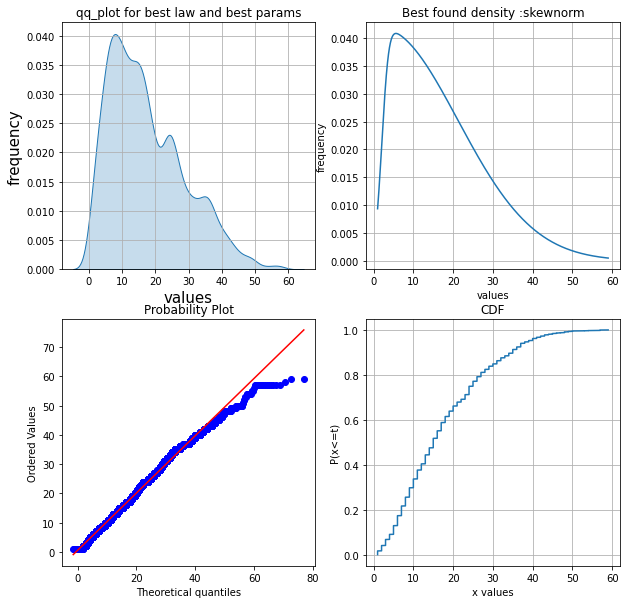

################################################
________________PER_License_Age_Second_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7141.000000
mean        0.810811
std         5.460803
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        43.000000
Name: PER_License_Age_Second_Driver, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


                     stat value        p-value
gamma ks test          0.085033   5.682046e-07
alpha ks test          0.273753   3.651133e-69
beta ks test           0.176174   1.268560e-28
skewnorm ks test       0.066323   2.073317e-04
expon ks test          0.102137   7.164370e-10
cauchy ks test         0.166874   1.041747e-25
norm ks test           0.126161   7.581227e-15
weibull_min ks test    0.360661  2.571950e-121
uniform ks test        0.436791  1.649195e-180
gumbel_r ks test       0.077141   8.180337e-06
_______________________Plots cdf/df_______________________


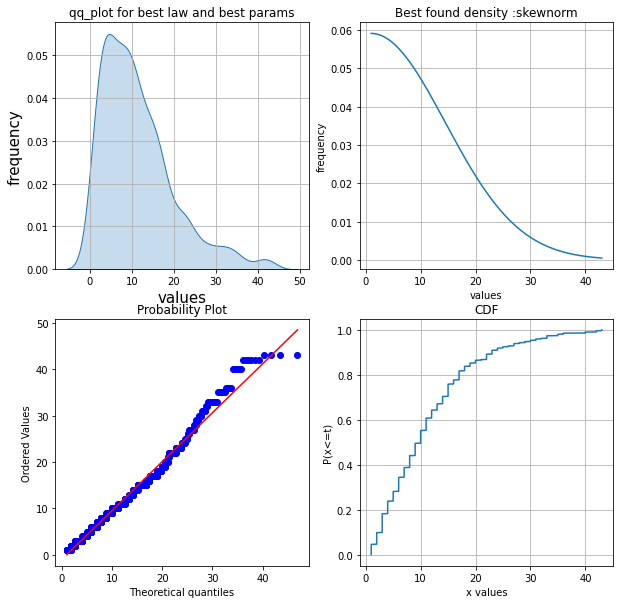

################################################
________________VEH_Age__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean        8.798389
std         5.000353
min         0.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        29.000000
Name: VEH_Age, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


                     stat value        p-value
gamma ks test          0.065465   3.536277e-29
alpha ks test          0.081646   3.784278e-45
beta ks test           0.059218   5.946410e-24
skewnorm ks test       0.061191   1.513816e-25
expon ks test          0.209764  1.257465e-295
cauchy ks test         0.130963  1.713563e-115
norm ks test           0.105228   1.030342e-74
weibull_min ks test    0.517105   0.000000e+00
uniform ks test        0.392931   0.000000e+00
gumbel_r ks test       0.073255   1.991247e-36
_______________________Plots cdf/df_______________________


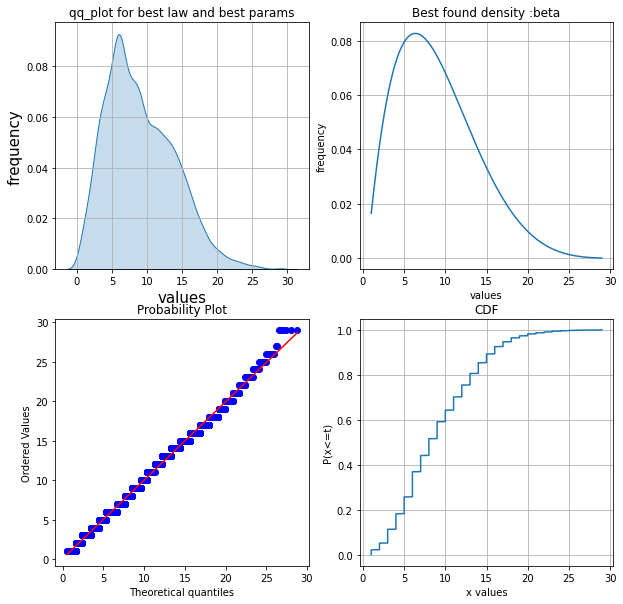

################################################
________________VEH_engine_HP__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean      116.572993
std        41.927616
min        24.000000
25%        90.000000
50%       110.000000
75%       140.000000
max       625.000000
Name: VEH_engine_HP, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.060710  7.295048e-26
alpha ks test          0.060908  4.974872e-26
beta ks test           0.060602  8.983871e-26
skewnorm ks test       0.074247  1.795638e-38
expon ks test          0.306916  0.000000e+00
cauchy ks test         0.101508  1.531153e-71
norm ks test           0.085529  6.501080e-51
weibull_min ks test    0.802124  0.000000e+00
uniform ks test        0.681310  0.000000e+00
gumbel_r ks test       0.066772  3.382930e-31
_______________________Plots cdf/df_______________________


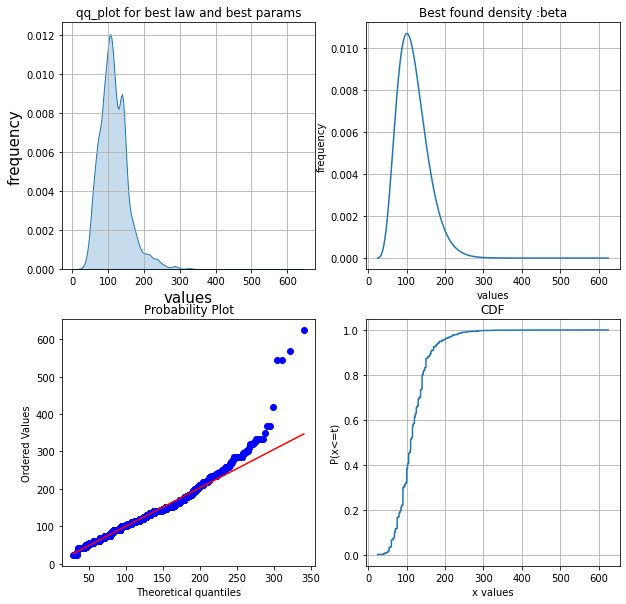

################################################
________________VEH_pw_proportion__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean       64.605714
std        14.886200
min        30.000000
25%        55.000000
50%        63.000000
75%        72.000000
max       304.000000
Name: VEH_pw_proportion, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.042361  8.245002e-13
alpha ks test          0.033261  4.629507e-08
beta ks test           0.042939  3.763665e-13
skewnorm ks test       0.051540  9.273157e-19
expon ks test          0.324393  0.000000e+00
cauchy ks test         0.102786  2.417560e-73
norm ks test           0.089715  5.615384e-56
weibull_min ks test    0.075835  4.066421e-40
uniform ks test        0.734458  0.000000e+00
gumbel_r ks test       0.036681  1.034466e-09
_______________________Plots cdf/df_______________________


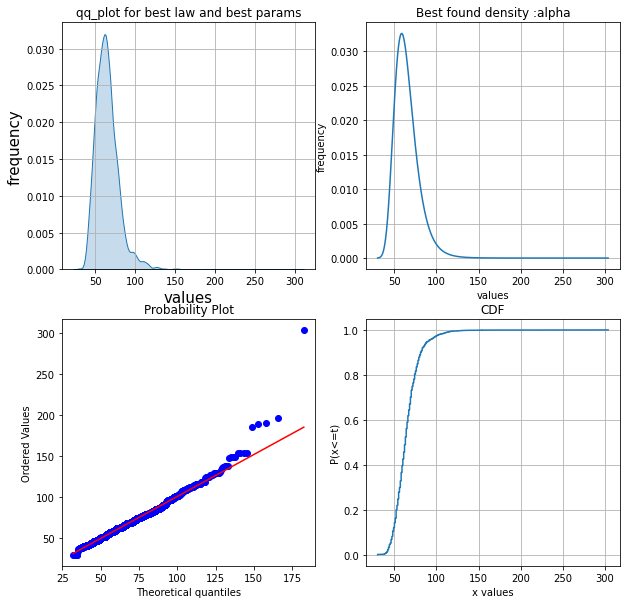

################################################
________________PER_Age_oldest_child__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean      -44.825069
std        55.364199
min       -99.000000
25%       -99.000000
50%       -99.000000
75%        10.000000
max        27.000000
Name: PER_Age_oldest_child, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


                     stat value        p-value
gamma ks test          0.198430  5.189101e-134
alpha ks test          0.094581   8.940481e-31
beta ks test           0.092746   1.310963e-29
skewnorm ks test       0.092060   3.526693e-29
expon ks test          0.118607   3.747989e-48
cauchy ks test         0.188071  1.988750e-120
norm ks test           0.116597   1.506544e-46
weibull_min ks test    0.339490   0.000000e+00
uniform ks test        0.185966  9.318274e-118
gumbel_r ks test       0.096918   2.710531e-32
_______________________Plots cdf/df_______________________


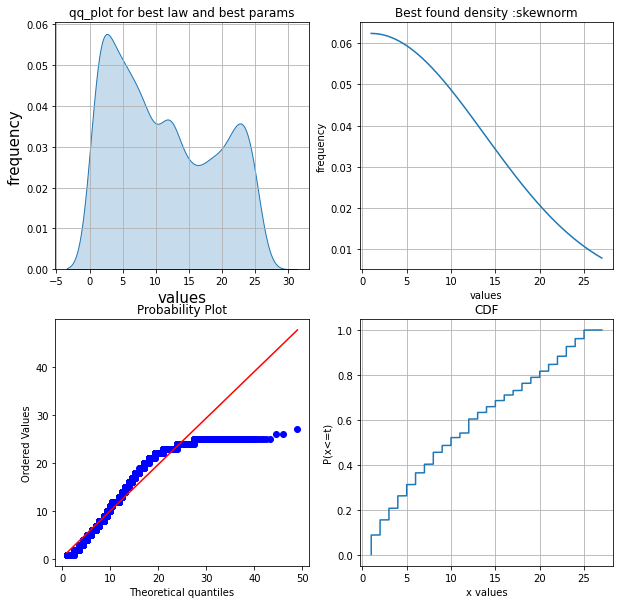

################################################
________________PER_Second_Driver_Age__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean        4.309464
std        13.034649
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        69.000000
Name: PER_Second_Driver_Age, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


                     stat value        p-value
gamma ks test          0.047960   6.712926e-03
alpha ks test          0.033714   1.190907e-01
beta ks test           0.058483   4.216048e-04
skewnorm ks test       0.054508   1.279157e-03
expon ks test          0.183272   1.167121e-36
cauchy ks test         0.126727   1.081235e-17
norm ks test           0.110212   1.772221e-13
weibull_min ks test    0.679758   0.000000e+00
uniform ks test        0.376690  2.044358e-157
gumbel_r ks test       0.037609   5.992332e-02
_______________________Plots cdf/df_______________________


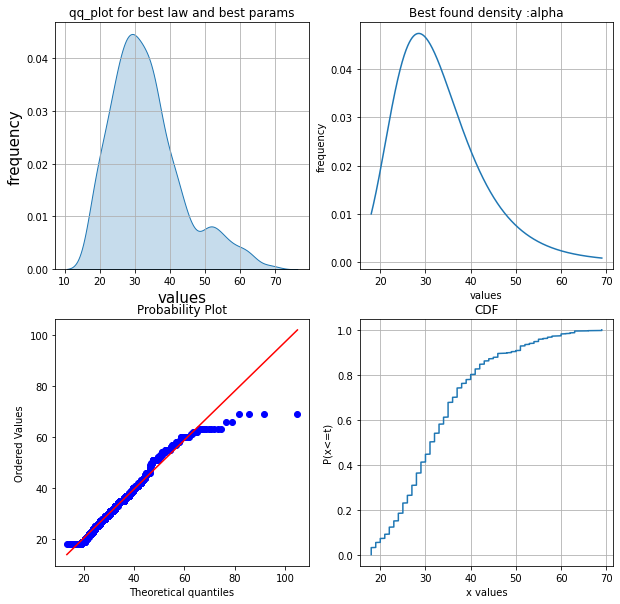

################################################
________________VEH_Weight__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean     1315.393783
std       248.375705
min       600.000000
25%      1160.000000
50%      1320.000000
75%      1470.000000
max      2475.000000
Name: VEH_Weight, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.030821  5.558775e-07
alpha ks test          0.048347  1.473839e-16
beta ks test           0.031016  4.585404e-07
skewnorm ks test       0.030328  8.971084e-07
expon ks test          0.334161  0.000000e+00
cauchy ks test         0.073159  2.294538e-37
norm ks test           0.032639  8.884313e-08
weibull_min ks test    0.832298  0.000000e+00
uniform ks test        0.370824  0.000000e+00
gumbel_r ks test       0.076980  2.520951e-41
_______________________Plots cdf/df_______________________


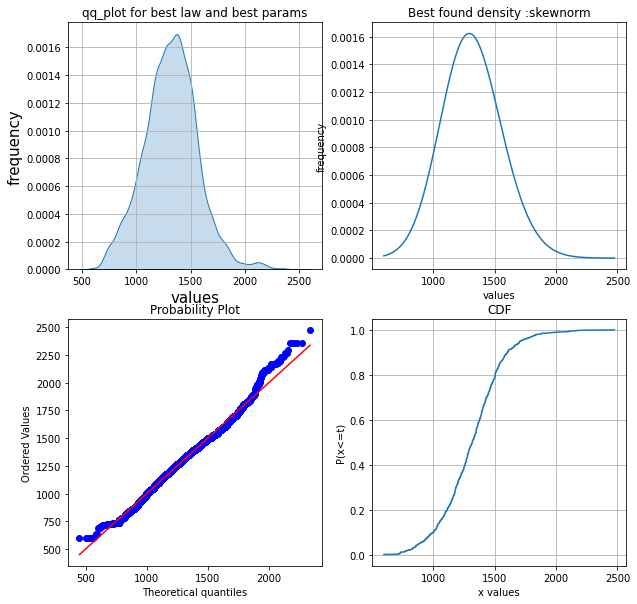

In [ ]:
analyzer.is_categorical = False

for element in quantitative :

  print('################################################')
  print("________________" + element + "__________________")
  print("#################################################")

  analyzer.get_univariate_statistics(X_train[element])
  

Let's note that some of the previous plots are irrelevent (the kde windows are not adjusted, and the cdf are strongly dependant of the missing values - not NA). Moreover, some of variables are treated as continuous, while they take integer values...

################################################
________________BEH_Mileage__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean       13.312484
std         1.022165
min        12.000000
25%        13.000000
50%        13.000000
75%        14.000000
max        18.000000
Name: BEH_Mileage, dtype: float64
_________________plots________________


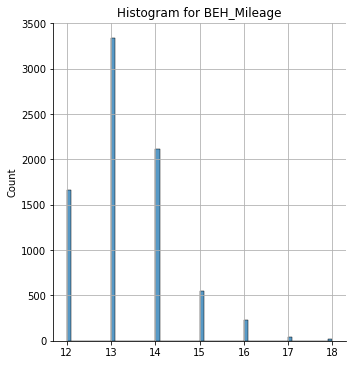

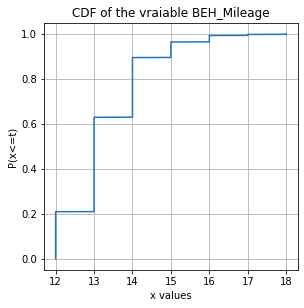

################################################
________________BEH_Number_Year_Insured__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean        6.455701
std         3.968423
min        -1.000000
25%         3.000000
50%         7.000000
75%        10.000000
max        10.000000
Name: BEH_Number_Year_Insured, dtype: float64
_________________plots________________


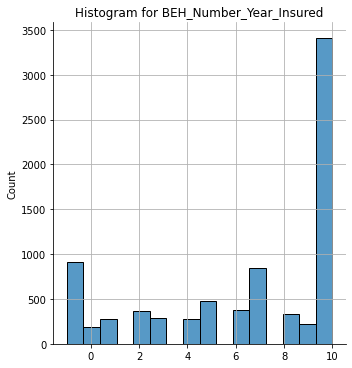

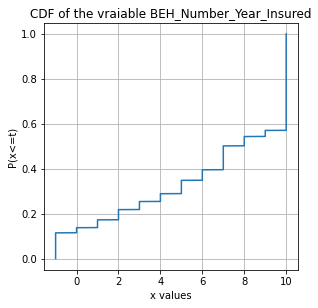

################################################
________________VEH_Number_of_doors__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7361.000000
mean        4.616900
std         0.724162
min         2.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: VEH_Number_of_doors, dtype: float64
_________________plots________________


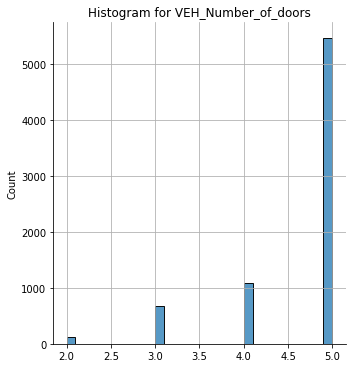

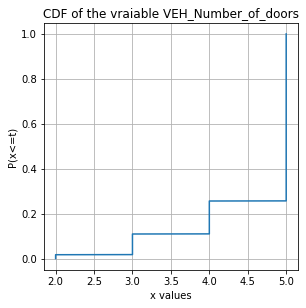

################################################
________________CLA_HISTORY__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean        1.494588
std         1.913033
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: CLA_HISTORY, dtype: float64
_________________plots________________


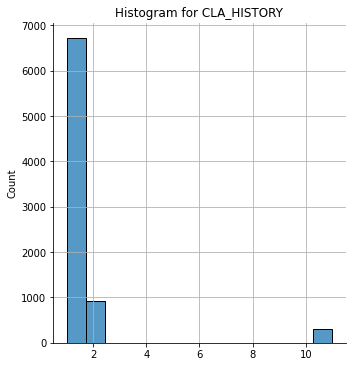

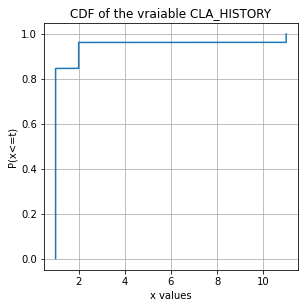

################################################
________________CLA_HISTORY_1Y__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean        1.132016
std         0.987685
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: CLA_HISTORY_1Y, dtype: float64
_________________plots________________


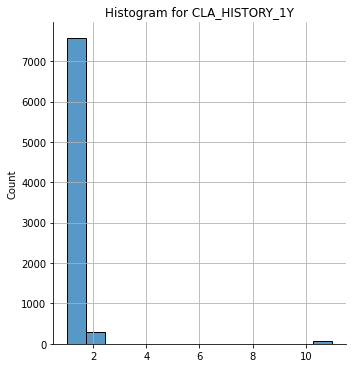

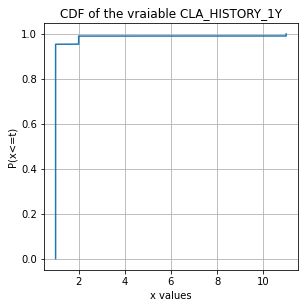

################################################
________________CLA_HISTORY_3Y__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.00000
mean        1.31110
std         1.50112
min         1.00000
25%         1.00000
50%         1.00000
75%         1.00000
max        11.00000
Name: CLA_HISTORY_3Y, dtype: float64
_________________plots________________


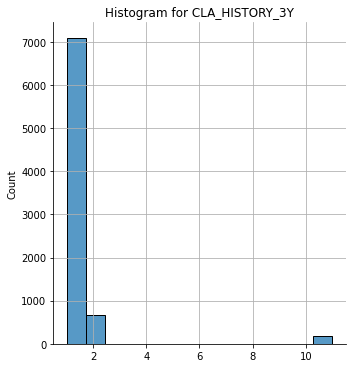

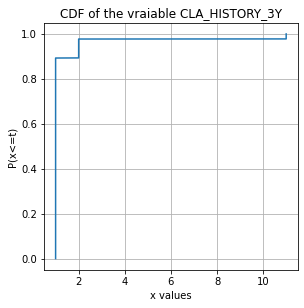

################################################
________________CLA_BM_TPL_DECLARED__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean        1.671910
std         2.215049
min        -1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: CLA_BM_TPL_DECLARED, dtype: float64
_________________plots________________


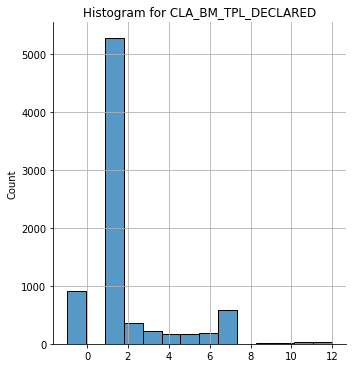

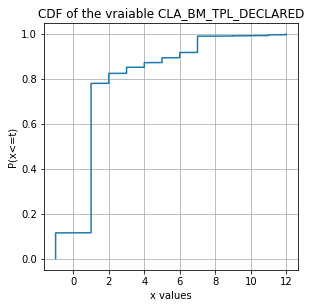

################################################
________________CLA_BM__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7946.000000
mean        6.411528
std         3.779017
min         0.000000
25%         3.000000
50%         7.000000
75%        10.000000
max        10.000000
Name: CLA_BM, dtype: float64
_________________plots________________


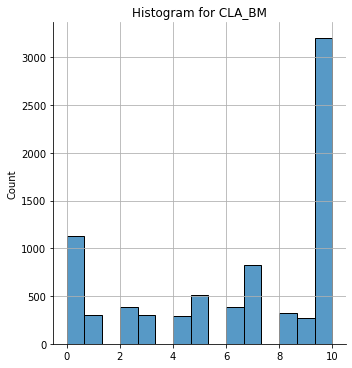

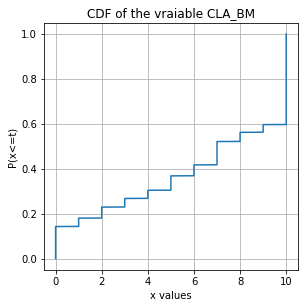

In [ ]:
analyzer.is_categorical = True

for element in as_quantitative :

  print('################################################')
  print("________________" + element + "__________________")
  print("#################################################")

  analyzer.get_univariate_statistics(X_train[element])

### Qualitative variables

In [ ]:
print('X shape :', X_train[qualitative].shape)

X_train[qualitative].describe(include = [object])

X shape : (7986, 17)


,PROD_Formula,PER_sex,PER_Sex_Second_Driver,PER_KIDS_ON_BOARD_ID,VEH_TransmissionId,PER_Matrimonial_Status,VEH_Injection_Mode,VEH_fuel_type,BEH_vehicule_usage,VEH_Drive_type,VEH_Body,VEH_Segment,PER_Parking_Type,VEH_High_Risk_Vehicle,PER_previous_insurer,PER_Is_second_driver,PER_Insured_Before
count,7986,7986,7986,7946,7946,7141,5897,7946,7946,7946,7946,7946,7946,7946,7946,7946,7946
unique,2,2,3,3,2,4,5,2,1,8,11,8,4,2,15,2,3
top,FULL,1,0,2,7,2,389999,1,1,50001,10,30003,2,2,27,1,2
freq,5086,6144,6745,3100,7264,4649,2971,4411,7946,6871,3782,3361,4633,7283,1523,6715,3547


7942/7986 : are the missing_values the sames???

VEH_Drive_type & VEH_Body : large number of bins, should they be treated as quantitative variables ??

################################################
________________PROD_Formula__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7986
unique       2
top       FULL
freq      5086
Name: PROD_Formula, dtype: object
_________________plots________________


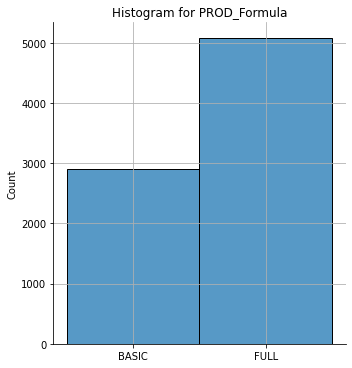

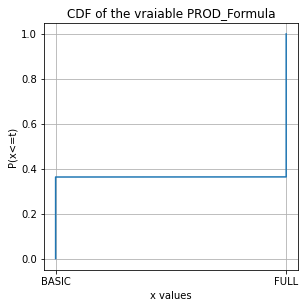

################################################
________________PER_sex__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7986
unique       2
top          1
freq      6144
Name: PER_sex, dtype: object
_________________plots________________


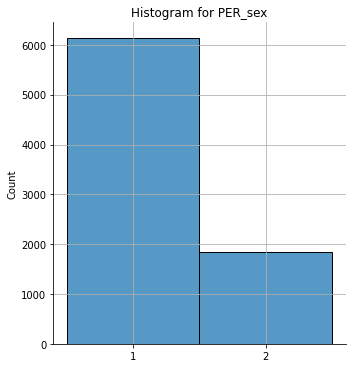

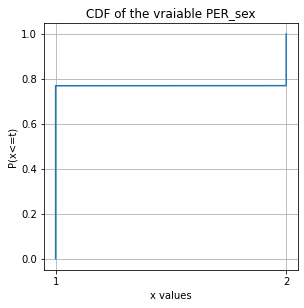

################################################
________________PER_Sex_Second_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7986
unique       3
top          0
freq      6745
Name: PER_Sex_Second_Driver, dtype: object
_________________plots________________


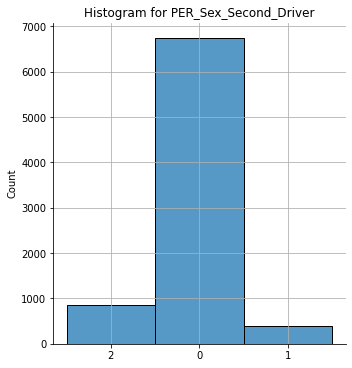

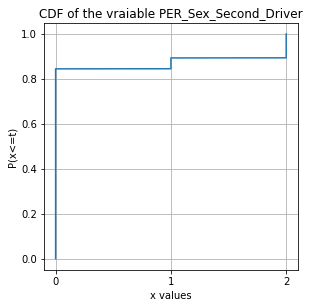

################################################
________________PER_KIDS_ON_BOARD_ID__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       3
top          2
freq      3100
Name: PER_KIDS_ON_BOARD_ID, dtype: object
_________________plots________________


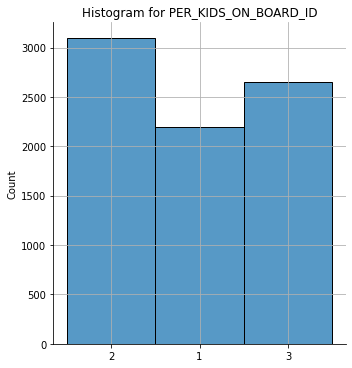

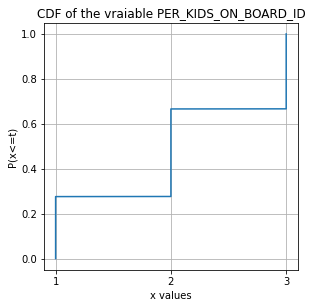

################################################
________________VEH_TransmissionId__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       2
top          7
freq      7264
Name: VEH_TransmissionId, dtype: object
_________________plots________________


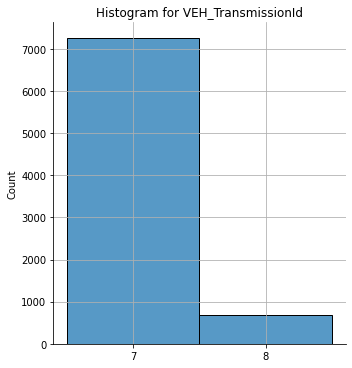

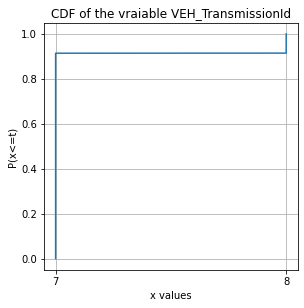

################################################
________________PER_Matrimonial_Status__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7141
unique       4
top          2
freq      4649
Name: PER_Matrimonial_Status, dtype: object
_________________plots________________


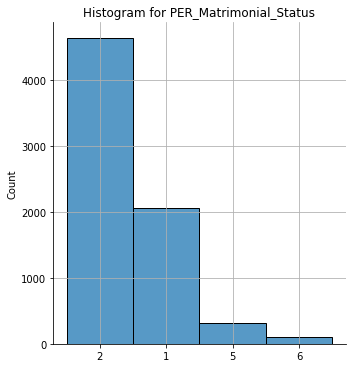

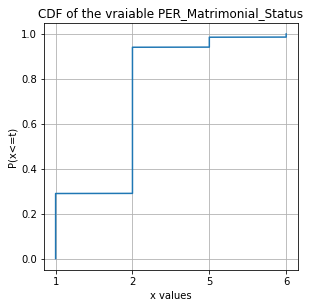

################################################
________________VEH_Injection_Mode__________________
#################################################
__________________Summary statistics of the response variable__________________
count       5897
unique         5
top       389999
freq        2971
Name: VEH_Injection_Mode, dtype: object
_________________plots________________


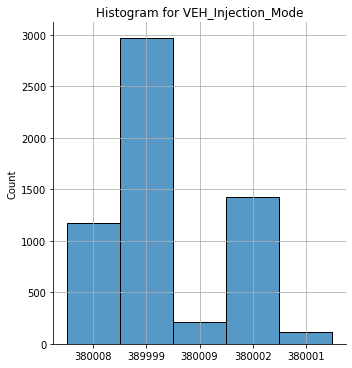

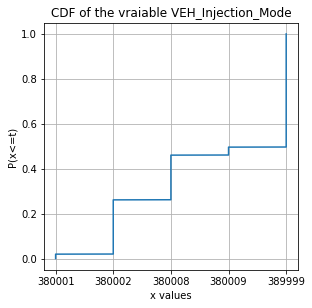

################################################
________________VEH_fuel_type__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       2
top          1
freq      4411
Name: VEH_fuel_type, dtype: object
_________________plots________________


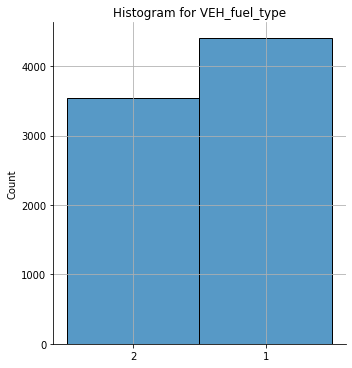

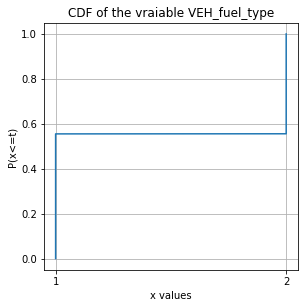

################################################
________________BEH_vehicule_usage__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       1
top          1
freq      7946
Name: BEH_vehicule_usage, dtype: object
_________________plots________________


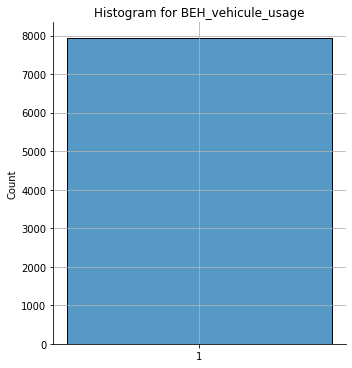

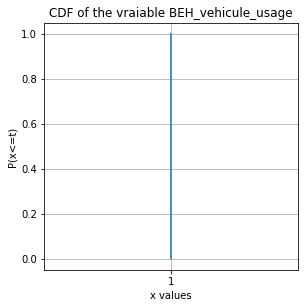

################################################
________________VEH_Drive_type__________________
#################################################
__________________Summary statistics of the response variable__________________
count      7946
unique        8
top       50001
freq       6871
Name: VEH_Drive_type, dtype: object
_________________plots________________


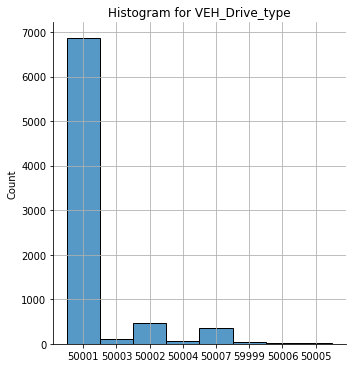

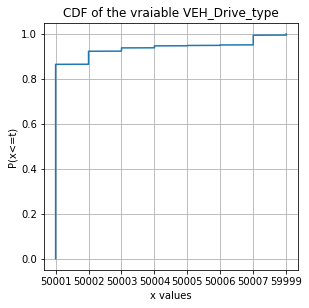

################################################
________________VEH_Body__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique      11
top         10
freq      3782
Name: VEH_Body, dtype: object
_________________plots________________


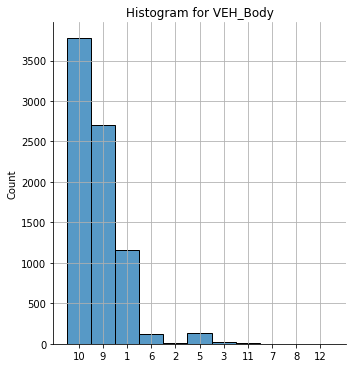

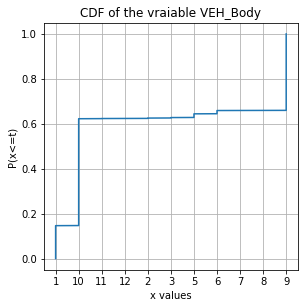

################################################
________________VEH_Segment__________________
#################################################
__________________Summary statistics of the response variable__________________
count      7946
unique        8
top       30003
freq       3361
Name: VEH_Segment, dtype: object
_________________plots________________


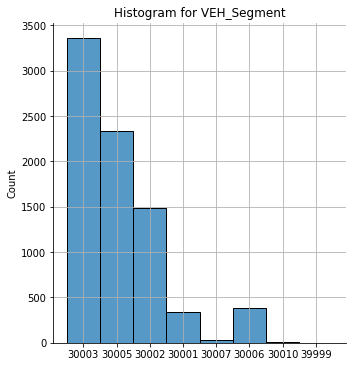

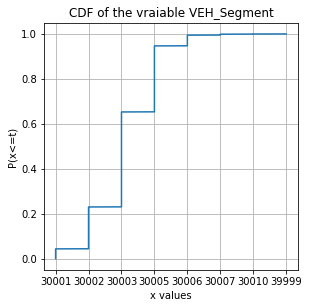

################################################
________________PER_Parking_Type__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       4
top          2
freq      4633
Name: PER_Parking_Type, dtype: object
_________________plots________________


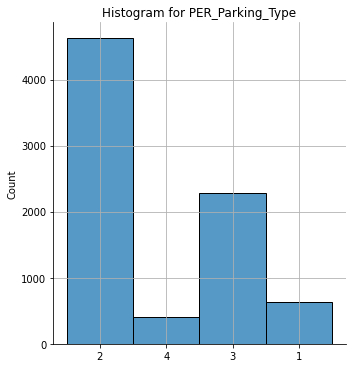

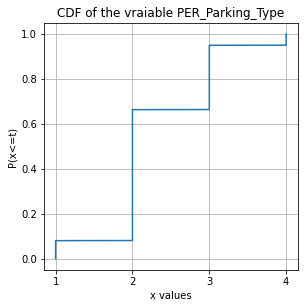

################################################
________________VEH_High_Risk_Vehicle__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       2
top          2
freq      7283
Name: VEH_High_Risk_Vehicle, dtype: object
_________________plots________________


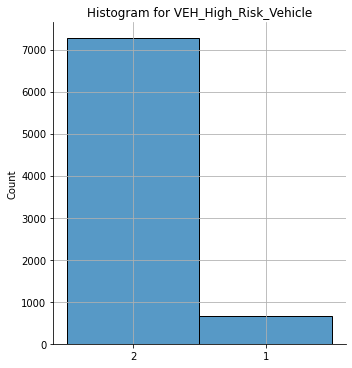

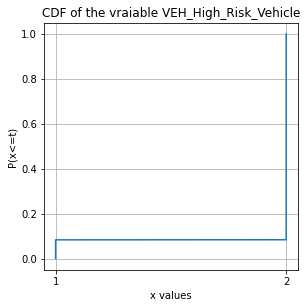

################################################
________________PER_previous_insurer__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique      15
top         27
freq      1523
Name: PER_previous_insurer, dtype: object
_________________plots________________


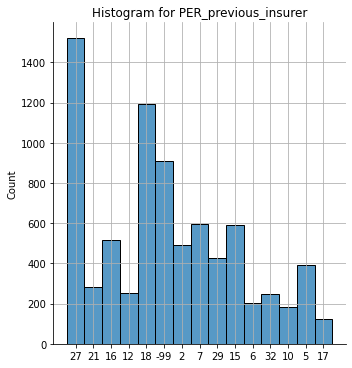

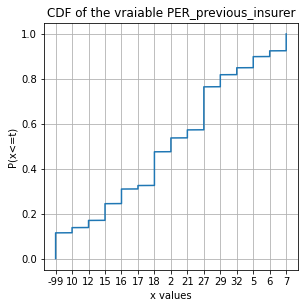

################################################
________________PER_Is_second_driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       2
top          1
freq      6715
Name: PER_Is_second_driver, dtype: object
_________________plots________________


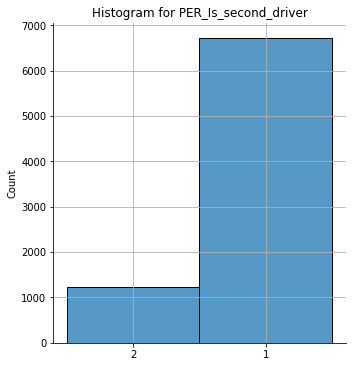

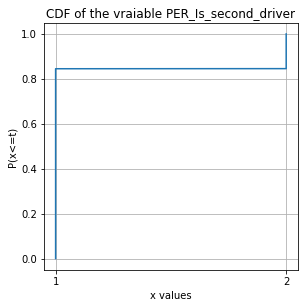

################################################
________________PER_Insured_Before__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7946
unique       3
top          2
freq      3547
Name: PER_Insured_Before, dtype: object
_________________plots________________


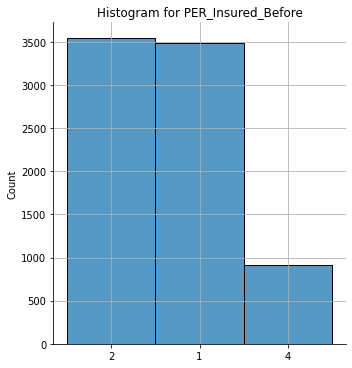

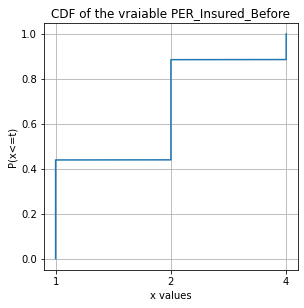

In [ ]:
for element in qualitative :

  analyzer.is_categorical = True

  print('################################################')
  print("________________" + element + "__________________")
  print("#################################################")

  analyzer.get_univariate_statistics(X_train[element])
 

- **PROD_Formula** no missing values, FULL/BASIC to encode as 0/1
- **PER_sex** no missing values, 1/2 to encode as 0/1
- **PER_Sex_Second_Driver** no NA, missing values encoded by 0 (if the default encoding for M/W is the same as before). To replace by flag second driver 0/1 and is_man_second_driver 0/1 (get dummies at least). The 0s mean that there is no 2nd driver.
- **PER_KIDS_ON_BOARD_ID** 7945/7986 values. 1/2/3 we must get dummies.
- **VEH_TransmissionId**  7945/7986 values : 7/8 :  to encode as 0/1
- **PER_Matrimonial_Status** 7151/7986 values. 1/2/5/6 we must get dummies.
- **VEH_Injection_Mode** 5930/7986 values. Arbitrary encoding : we need to get dummies.
- **VEH_fuel_type** 7945/7986 values. 1/2 to encode as 0/1
- **BEH_vehicule_usage** 7945/7948 : 1 unique modality. To delete (it can't be discriminant for the response variable).
- **VEH_Drive_type** 7945/7986 values. 8 modalities, it could maybe be treated as a quantitative variable, however the variable name tells us that it is a type of vehicle so that there is no distance between its values. We will get dummies.
- **VEH_Body** 7945/7986. 10 modalities. Same reflexion as VEH_Drive_Type.
- **VEH_Segment** 7945/7986. 8 modalities. Same reflexion as VEH_Drive_Type. We must check for lienar independance between VEH_Segment and VEH_Drive_Type.
- **PER_Parking_Type** 7945/7986. 1/2/3/4, we will get dummies.
- **VEH_High_Risk_Vehicle** 7945/7986. 1/2 -> 0/1
- **PER_previous_insurer** 7945/7986. 15 modalities -> get dummies
- **PER_Is_second_driver** 7945/7986. 1/2 -> 0/1
- **PER_Insured_Before** 7945/7986. insured before 1/2/4 -> get dummies (but beware of value 3!!! in test sets).

We will really have to check if the missing values are the sames!

Most of cdfs have no sense here.

## 2. Multivariate analysis


### Correlations between features

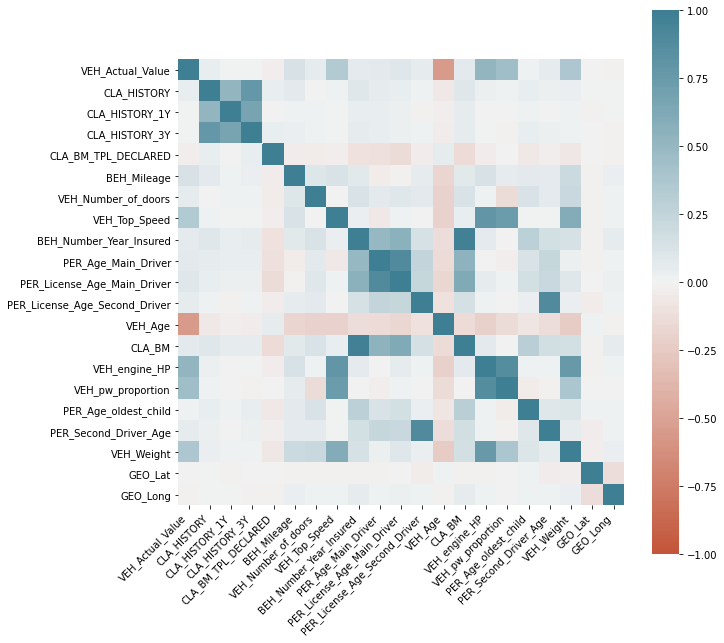

In [ ]:
corr = X_train.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
figsize(20, 20)
show(ax)

**Strong correlations**

- CLA_HISTORY_1Y / CLA_HISTORY_2Y / CLA_HISTORY_3Y

- VEH_VALUE with VEH_ACTUAL_VALUE (value decreases wwith age in general), VEH_engine_hp, VEH_pw_proportion, VEH_weight

- VEH_TOP_SPEED with VEH_engine_hp, VEH_pw_proportion (speed depends on these ok), VEH_weight

- BEH_NUMBER_YEAR_INSURED / PER_MAIN_AGE_DRIVER / PER_LICENCE_AGE_MAIN_DRIVER / CLA_BM

- PER_LICENCE_SECOND_MAIN_DRIVER / PER_SECOND_DRIVER_AGE ok

### Correlation features/response

## 3. Missing values

### The 50 missing values

In [ ]:
X_train_50mv = X_train.loc[X_train['CLA_HISTORY'].isnull()]
X_train_50mv.describe()

,VEH_Actual_Value,CLA_HISTORY,CLA_HISTORY_1Y,CLA_HISTORY_3Y,CLA_BM_TPL_DECLARED,BEH_Mileage,VEH_Number_of_doors,VEH_Top_Speed,BEH_Number_Year_Insured,PER_Age_Main_Driver,PER_License_Age_Main_Driver,PER_License_Age_Second_Driver,VEH_Age,CLA_BM,VEH_engine_HP,VEH_pw_proportion,PER_Age_oldest_child,PER_Second_Driver_Age,VEH_Weight,GEO_Lat,GEO_Long
count,40.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.000000,40.000000
mean,19008.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.366814,0.659483
std,13150.317381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045431,2.505243
min,1800.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.301624,-4.097747
25%,7948.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.326624,-0.618622
50%,14340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.358524,0.368853
75%,35890.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.425824,3.045878
max,39603.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.425824,3.918653


As expected the 50 missing values found for 'CLA_HISTORY' are at least missing everywhere. Inputation for these is not efficient, we will split the data into 2 samples, such that we will build 2 models (1 for the 50 missing values and 1 for the rest).

In [ ]:
X_train_wo50mv = X_train.loc[X_train['CLA_HISTORY'].notnull()]

### Correlation between missing values

**For the full dataset**

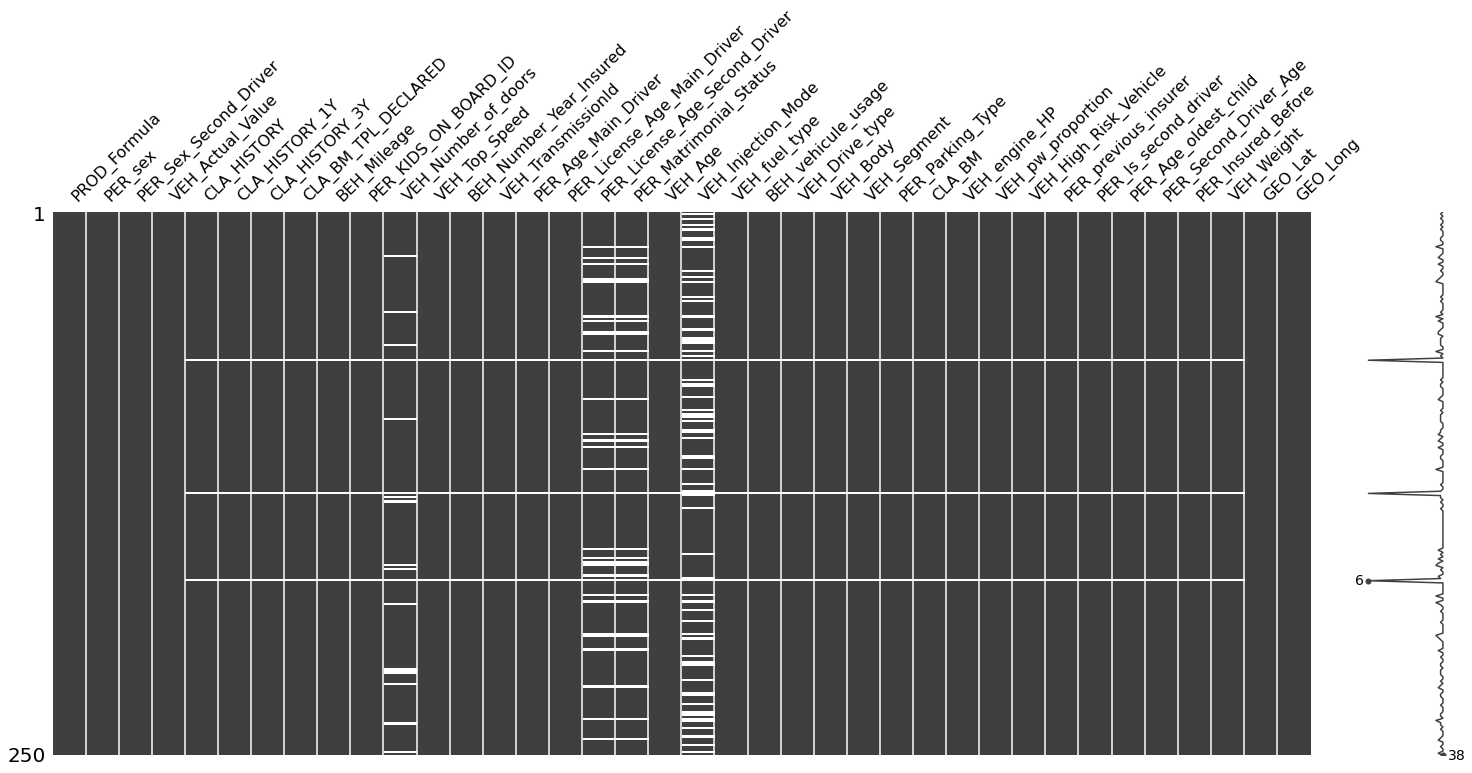

In [ ]:
missingno.matrix(X_train.sample(250))

**For the data set wo 50 missing values**

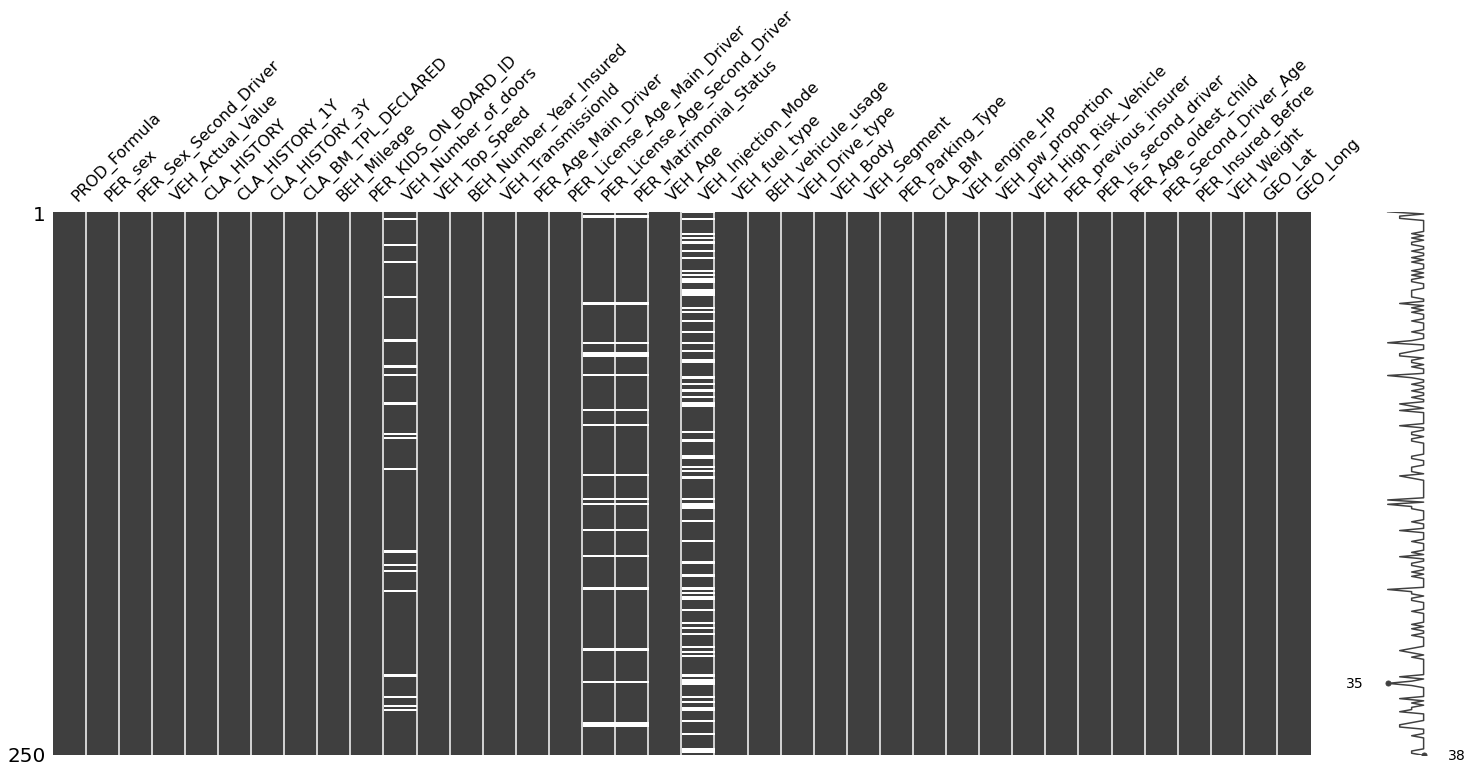

In [ ]:
missingno.matrix(X_train_wo50mv.sample(250))

PER_Licence_Age_Second_Driver & Per_Licence_Age_Main_Driver have correlated missing values (case no 2nd driver I guess).

In [ ]:
del X_train_50mv, X_train_wo50mv

## 4. Preprocessing 

Now geographical data will be treated as quantitative variables.

In [19]:
quantitative = quantitative + geographical

We will spilt the data into 2 datasets for 2 models : the  main and the one with the "50 missing values".

- For quantitative and geographical data : we will center/reduce and imput missing values (with initial strategy = mean).

- For qualitative data : we will get dummies, and imput missing values (with initial_strategy = median).

- For as_quantitative data : we will center/ reduce and imput missing values (with initial strategy = median).

In [20]:
class Custom_data_cleaner():

  def __init__(self, quantitative, as_quantitative, qualitative):

    self.quantitative = quantitative
    self.qualitative = qualitative
    self.as_quantitative = as_quantitative


  def split_50(self, XX):

    X = XX.copy()
    where_50_values = X['CLA_HISTORY'].isnull()
    where_50_values = where_50_values

    X_50 = X.loc[where_50_values]
    assert len(X_50[['VEH_Actual_Value', 'GEO_Lat', 'GEO_Long']].dropna()) == len(X_50), 'Key for suspect 50 values is wrong'
    X_wo50 = X.loc[X['CLA_HISTORY'].notnull()]

    self.where_50_values = where_50_values

    return X_50, X_wo50



  def preprocessing(self, XX, dummies = True, check = True):

    quantitative = self.quantitative
    qualitative = self.qualitative
    as_quantitative = self.as_quantitative
    X = XX.copy()

    scaler = preprocessing.StandardScaler().fit(X[quantitative + as_quantitative])
    X[quantitative + as_quantitative] = scaler.transform(X[quantitative + as_quantitative])

    if dummies : 
      X = pd.get_dummies(X, columns = qualitative, drop_first  = True)
      if check :
        for key in self.KEYS :
          if not(key in X.columns) : X[key] = zeros(X.shape[0])
        for key in X.columns :
          if not(key in self.KEYS) : del X[key]
      

    return X

  
  
  def fit(self, XX, y = None):

    quantitative = self.quantitative
    qualitative = self.qualitative
    as_quantitative = self.as_quantitative
    X = XX.copy()
    
    X_50, X_wo50 = self.split_50(X)

    X_wo50 = self.preprocessing(X_wo50, check = False)
    self.KEYS = X_wo50.columns

    imputer_quantitative = IterativeImputer()
    X_wo50_quantitative = X_wo50[quantitative]
    #print(X_wo50_quantitative)
    imputer_quantitative.fit(X_wo50_quantitative)
    self.imputer_quantitative = imputer_quantitative

    new_qualitative = list(X_wo50.keys())
    for element in quantitative : new_qualitative.remove(element)
    self.new_qualitative = new_qualitative

    imputer_qualitative = IterativeImputer(initial_strategy = "median")
    X_wo50_qualitative = X_wo50[new_qualitative]
    imputer_qualitative.fit(X_wo50_qualitative)
    self.imputer_qualitative = imputer_qualitative

   
  def imput_missing_values(self, XX_wo50):
    quantitative = self.quantitative
    qualitative = self.new_qualitative
    qualitative_imputer = self.imputer_qualitative
    quantitative_imputer = self.imputer_quantitative
    X_wo50 = XX_wo50.copy()
    X_wo50 = self.preprocessing(X_wo50)
    X_wo50_quantitative = X_wo50[quantitative]
    X_wo50_qualitative = X_wo50[qualitative]
    X_wo50[quantitative] = quantitative_imputer.transform(X_wo50_quantitative)
    X_wo50[qualitative] = qualitative_imputer.transform(X_wo50_qualitative)
    return X_wo50


  def transform(self, XX, y = None):

    quantitative = self.quantitative
    new_qualitative = self.new_qualitative
    qualitative = self.qualitative

    X = XX.copy()
    X_50, X_wo50 = self.split_50(X)
    X_wo50 = self.imput_missing_values(X_wo50)
    X_50 = self.preprocessing(X_50, dummies = False, check = False)
    X_50 = X_50[['VEH_Actual_Value', 'GEO_Lat', 'GEO_Long']]
    return X_50, X_wo50


  def fit_transform(self, X, y = None):

    self.fit(X)
    return self.transform(X)


**TESTS**

In [21]:
processor = Custom_data_cleaner(quantitative, as_quantitative, qualitative)
X_50_test, X_wo50_test = processor.fit_transform(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [22]:
X_50_test.describe()

,VEH_Actual_Value,GEO_Lat,GEO_Long
count,4.000000e+01,4.000000e+01,4.000000e+01
mean,-5.551115e-17,1.100010e-14,-3.330669e-17
std,1.012739e+00,1.012739e+00,1.012739e+00
min,-1.354607e+00,-1.331580e+00,-1.795530e+00
25%,-8.894153e-01,-7.608353e-01,-5.118121e-01
50%,-3.689603e-01,1.037717e-02,-6.669499e-02
75%,1.176290e+00,8.098910e-01,9.694699e-01
max,1.449563e+00,1.597613e+00,1.307285e+00


In [23]:
X_wo50_test.describe()

,VEH_Actual_Value,CLA_HISTORY,CLA_HISTORY_1Y,CLA_HISTORY_3Y,CLA_BM_TPL_DECLARED,BEH_Mileage,VEH_Number_of_doors,VEH_Top_Speed,BEH_Number_Year_Insured,PER_Age_Main_Driver,PER_License_Age_Main_Driver,PER_License_Age_Second_Driver,VEH_Age,CLA_BM,VEH_engine_HP,VEH_pw_proportion,PER_Age_oldest_child,PER_Second_Driver_Age,VEH_Weight,GEO_Lat,GEO_Long,PROD_Formula_FULL,PER_sex_2,PER_Sex_Second_Driver_1,PER_Sex_Second_Driver_2,PER_KIDS_ON_BOARD_ID_2,PER_KIDS_ON_BOARD_ID_3,VEH_TransmissionId_8,PER_Matrimonial_Status_2,PER_Matrimonial_Status_5,PER_Matrimonial_Status_6,VEH_Injection_Mode_380002,VEH_Injection_Mode_380008,VEH_Injection_Mode_380009,VEH_Injection_Mode_389999,VEH_fuel_type_2,VEH_Drive_type_50002,VEH_Drive_type_50003,VEH_Drive_type_50004,VEH_Drive_type_50005,VEH_Drive_type_50006,VEH_Drive_type_50007,VEH_Drive_type_59999,VEH_Body_10,VEH_Body_11,VEH_Body_2,VEH_Body_3,VEH_Body_5,VEH_Body_6,VEH_Body_7,VEH_Body_8,VEH_Body_9,VEH_Segment_30002,VEH_Segment_30003,VEH_Segment_30005,VEH_Segment_30006,VEH_Segment_30007,VEH_Segment_30010,VEH_Segment_39999,PER_Parking_Type_2,PER_Parking_Type_3,PER_Parking_Type_4,VEH_High_Risk_Vehicle_2,PER_previous_insurer_10,PER_previous_insurer_12,PER_previous_insurer_15,PER_previous_insurer_16,PER_previous_insurer_17,PER_previous_insurer_18,PER_previous_insurer_2,PER_previous_insurer_21,PER_previous_insurer_27,PER_previous_insurer_29,PER_previous_insurer_32,PER_previous_insurer_5,PER_previous_insurer_6,PER_previous_insurer_7,PER_Is_second_driver_2,PER_Insured_Before_2,PER_Insured_Before_4
count,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7946.000000,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7946.000000,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7.946000e+03,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.00000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000
mean,4.855305e-17,-2.721765e-16,3.756748e-16,5.470077e-17,7.088046e-17,8.385635e-16,-0.039453,2.127951e-17,-2.118589e-16,-2.713242e-16,-6.770879e-17,-0.005620,-1.576542e-16,-4.341131e-17,-6.006606e-17,7.310202e-17,-2.928552e-16,5.749589e-16,-2.334179e-16,7.368885e-17,7.600822e-18,0.639441,0.235590,0.048200,0.106846,0.389630,0.333627,0.084067,0.586584,0.040146,0.012711,0.179713,0.150768,0.027813,0.377297,0.448528,0.056884,0.015354,0.00818,0.002265,0.002139,0.042663,0.006167,0.484521,0.000629,0.001510,0.002014,0.017116,0.014221,0.000252,0.000126,0.335389,0.188397,0.425245,0.285175,0.050466,0.004531,0.000629,0.000252,0.575384,0.290964,0.050717,0.916184,0.024289,0.032343,0.074629,0.066071,0.015228,0.147747,0.059401,0.037377,0.195193,0.053486,0.027939,0.048075,0.025422,0.075636,0.155047,0.443494,0.117166
std,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,0.994948,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,0.982377,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,0.480193,0.424394,0.214203,0.308937,0.487697,0.471538,0.277506,0.492477,0.196314,0.112030,0.383972,0.357845,0.164446,0.484741,0.497375,0.231635,0.122963,0.09008,0.047544,0.046207,0.202109,0.078290,0.499792,0.025078,0.038834,0.044831,0.129710,0.118408,0.015864,0.011218,0.472156,0.391053,0.494411,0.451526,0.218918,0.067161,0.025078,0.015864,0.494316,0.454236,0.219434,0.277129,0.153954,0.176921,0.262

In [24]:
X_test.shape

(1997, 38)

## Pipeline

**I strongly recomment to do NOT run this part**

Because the purpose of this exercise is not to chose a model or to tune hyperparameters, and also because we must not over-feature engineer, we will build a pipeline (using the tpot - package). We will then check the auto-generated code.

#### Preparation

In [ ]:
class Custom_pipeline() :

  def __init__(self, quantitative, as_quantitative, qualitative, random_state = 2021):

    self.data_cleaner = Custom_data_cleaner(quantitative, as_quantitative, qualitative)
    self.random_state = random_state


  def fit(self, 
          X, 
          yy,
          path_model50 = 'TPOTmodel_50.py', 
          path_modelwo50 = 'TPOTmodel_wo50.py',
          fit_50 = True,
          fit_wo50 = False):

      random_state = self.random_state
      X_50, X_wo50 = self.data_cleaner.fit_transform(X)
      where_50_values = self.data_cleaner.where_50_values
      y = yy.values
      y_50 = y[where_50_values]
      y_wo50 = y[where_50_values == False]
     
      if(fit_50):
        print('################# 50 missing values ###############')
        self.model_50 = tpot.TPOTRegressor(generations = 100, 
                                      population_size = 100, 
                                      cv = 5, 
                                      scoring = 'neg_mean_absolute_error', 
                                      verbosity = 2, 
                                      random_state = random_state, 
                                      n_jobs = 50)
        
        self.model_50.fit(X_50, y_50)
        self.model_50.export(path_model50)

      if(fit_wo50):
        print('###############Other data####################')
        self.model_wo50 = tpot.TPOTRegressor(generations = 30, 
                                            population_size = 50, 
                                            cv = 3, 
                                            scoring = 'neg_mean_absolute_error', 
                                            verbosity = 2 , 
                                            random_state = random_state, 
                                            n_jobs = 100)
        self.model_wo50.fit(X_wo50, y_wo50)
        self.model_wo50.export(path_modelwo50)


  def export_model(self, 
                   path_model50 = 'TPOTmodel_50.py', 
                   path_modelwo50 = 'TPOTmodel_wo50.py'):
    self.model_wo50.export('tpot_insurance_best_model.py')
    self.model_50.export('tpot_insurance_best_model.py')
  



#### Model wo50

In [ ]:
pipeline = Custom_pipeline(quantitative, as_quantitative, qualitative)
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


###############Other data####################



Generation 1 - Current best internal CV score: -53.88711247620292

Generation 2 - Current best internal CV score: -51.451430447130754

Generation 3 - Current best internal CV score: -51.00730985743282

Generation 4 - Current best internal CV score: -45.91746656071668

Generation 5 - Current best internal CV score: -45.91746656071668

Generation 6 - Current best internal CV score: -45.16335898418129

Generation 7 - Current best internal CV score: -43.60887164350379

Generation 8 - Current best internal CV score: -43.23716047926047

Generation 9 - Current best internal CV score: -40.43670837123528

Generation 10 - Current best internal CV score: -36.1607702888552

Generation 11 - Current best internal CV score: -36.04732018443593

Generation 12 - Current best internal CV score: -36.04732018443593

Generation 13 - Current best internal CV score: -36.04732018443593

Generation 14 - Current best internal CV score: -36.04732018443593

Generation 15 - Current best internal CV score: -36.0473

#### Model 50

In [ ]:
pipeline = Custom_pipeline(quantitative, as_quantitative, qualitative)
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


################# 50 missing values ###############



Generation 1 - Current best internal CV score: -28.011360612209057

Generation 2 - Current best internal CV score: -27.872027105592217

Generation 3 - Current best internal CV score: -27.872027105592217

Generation 4 - Current best internal CV score: -22.829641076642872

Generation 5 - Current best internal CV score: -22.829641076642872

Generation 6 - Current best internal CV score: -22.425155024819798

Generation 7 - Current best internal CV score: -22.425155024819798

Generation 8 - Current best internal CV score: -22.425155024819798

Generation 9 - Current best internal CV score: -22.425155024819798

Generation 10 - Current best internal CV score: -22.425155024819798

Generation 11 - Current best internal CV score: -22.425155024819798

Generation 12 - Current best internal CV score: -22.425155024819798

Generation 13 - Current best internal CV score: -22.425155024819798

Generation 14 - Current best internal CV score: -22.425155024819798

Generation 15 - Current best internal CV s

## 5. Model

In [25]:
class Full_model():

  def __init__(self, X, quantitative = quantitative, as_quantitative = as_quantitative, qualitative = qualitative, y = None):
    self.preprocessor = Custom_data_cleaner(quantitative, as_quantitative, qualitative)
    self.preprocessor.fit(X)

  
  def fit(self, X, y):
    X_50, X_wo50 = self.preprocessor.transform(X)
    where_50 = self.preprocessor.where_50_values
    y_50 = y[where_50]
    y_wo50 = y[where_50 == False]

    self.model_50 = make_pipeline(FeatureAgglomeration(affinity="euclidean", linkage="complete"),
                                  RobustScaler(),
                                  StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99, learning_rate=0.1, loss="ls", max_depth=10, max_features=0.7500000000000001, min_samples_leaf=11, min_samples_split=11, n_estimators=100, subsample=0.9500000000000001)),
                                  StackingEstimator(estimator=DecisionTreeRegressor(max_depth=2, min_samples_leaf=7, min_samples_split=14)),
                                  PCA(iterated_power=2, svd_solver="randomized"),
                                  StackingEstimator(estimator=XGBRegressor(learning_rate=0.001, max_depth=9, min_child_weight=13, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.9000000000000001, verbosity=0)),
                                  StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.2, tol=1e-05)),
                                  KNeighborsRegressor(n_neighbors=2, p=1, weights="distance")
                              )
    self.model_50.fit(X_50, y_50)

    self.model_wo50 = make_pipeline(VarianceThreshold(threshold=0.01),
                                    StackingEstimator(estimator=RandomForestRegressor(bootstrap=False, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=100)),
                                    StackingEstimator(estimator=RandomForestRegressor(bootstrap=False, max_features=0.45, min_samples_leaf=1, min_samples_split=4, n_estimators=100)),
                                    KNeighborsRegressor(n_neighbors=15, p=1, weights="distance"))
    self.model_wo50.fit(X_wo50, y_wo50)

  def predict(self, X):
    X_50, X_wo50 = self.preprocessor.transform(X)
    where_50 = self.preprocessor.where_50_values
    predictions_50 = self.model_50.predict(X_50)
    predictions_wo50 = self.model_wo50.predict(X_wo50)
    output = zeros(X.shape[0])
    output[where_50] = predictions_50
    output[where_50 == False] = predictions_wo50
    return output

  def eval_score(self, X, y):
    y_pred = self.predict(X)
    return mean(abs((y - y_pred) / y)) * 100

  

In [26]:
model = Full_model(X_train)
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [27]:
print('###########Calibration Score############')
print(model.eval_score(X_train, y_train))
print('############Prediction Score############')
print(model.eval_score(X_test, y_test) )

###########Calibration Score############


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


0.07353461386302829
############Prediction Score############


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


14.073299022772057
